In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from scipy.spatial.distance import cdist
from math import ceil

In [40]:
# Functions
def show_image(img, shape=(15, 15), img_type="bgr"):
    plt.rcParams["figure.figsize"] = shape
    if img_type == "bgr":
        plt.imshow(img[:, :, [2, 1, 0]])
    elif img_type.lower() == "gray":
        plt.imshow(img, cmap='gray')


def show_keypoints(img, keypoints):
    img = cv2.drawKeypoints(image=img, keypoints=keypoints, outImage=np.array(
        []), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    show_image(img)


def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def print_matches(matches):
    try:
        if type(matches[0]) not in (np.ndarray, list):
            for match in matches:
                print('Train=%4d Query=%4d Distance=%4.2f' %
                      (match.trainIdx, match.queryIdx, match.distance))
        else:
            for match_ in matches:
                for match in match_:
                    print('Train=%4d Query=%4d Distance=%4.2f' %
                          (match.trainIdx, match.queryIdx, match.distance))
    except:
        pass


def draw_matches(img1, img2, kp1, kp2, matches):
    img3 = cv2.drawMatches(img1, kp1, img2, kp2,
                           matches, outImg=np.array([]))  # , matchColor=(0, 255, 0))
    show_image(img3)

# https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html


def get_sift_features(img):
    if len(img.shape) == 3:
        img = to_grayscale(img)
    sift_obj = cv2.xfeatures2d.SIFT_create()
    return sift_obj.detectAndCompute(img, None)


def get_sift_features_and_show(img, show=False):
    keypoints = get_sift_features(img)
    if(show):
        show_keypoints(img, keypoints[0])
    return keypoints


def cv_matcher(img1, desc1, img2, desc2, kp1=None, kp2=None, threshold=0.75):
    brute_force_matcher = cv2.BFMatcher()

    # Match descriptors.
    matches = brute_force_matcher.knnMatch(desc1, desc2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < threshold * n.distance:
            good.append(m)

    if kp1 != None and kp2 != None:
        img3 = cv2.drawMatches(img1, kp1, img2, kp2,
                               good, outImg=np.array([]))  # , matchColor=(0, 255, 0))
        show_image(img3)

'''
    Gets matches for arr2 in arr1
'''
def knn_matcher(arr2, arr1, neighbours=2, img_id=0):
    assert neighbours == 2

    all_distances = np.sqrt(np.square(arr2).sum(
        axis=1)[:, np.newaxis] + np.square(arr1).sum(axis=1) - 2 * arr2.dot(arr1.T))

    closest_indices = np.argsort(all_distances, axis=1)[:, :neighbours]

    matches = []
    for i in range(closest_indices.shape[0]):
        match_list = [cv2.DMatch(
            _trainIdx=n, _queryIdx=i, _distance=all_distances[i, n], _imgIdx=img_id) for n in closest_indices[i]]
        matches.append(match_list)

    return matches


def filter_matches(matches, threshold=0.75):
    filtered = []
    for m, n in matches:
        if m.distance < threshold * n.distance:
            filtered.append(m)
    return filtered

'''
    Computes the homography matrix for the given points using 
    the Direct Linear transform
'''
def get_homography_matrix(pts1, pts2):
    eqn_list = []
    for (x1, y1), (x2, y2) in zip(pts1, pts2):
        row1 = [x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2]
        row2 = [0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2]
        eqn_list.append(row1)
        eqn_list.append(row2)

    # Solve for A.h = 0
    A = np.array(eqn_list)
#     print(A)kp1
    eig_values, eig_vectors = np.linalg.eig(np.dot(A.T, A))
    h_index = eig_values.argmin()
    h = eig_vectors[:, h_index]

    # Convert it to a unit vector
    h = h / np.linalg.norm(h)
    
    h /= h[-1]
    return h.reshape(3, 3)

def cv2_homography(matches, keypoints1, keypoints2):    
    pts1 = np.array([keypoints1[m.queryIdx].pt for m in matches])
    pts2 = np.array([keypoints2[m.trainIdx].pt for m in matches])
    return cv2.findHomography(pts1, pts2, cv2.RANSAC)[0]

def ransac(matches, kp1, kp2, sample_points=4, iterations=5, inlier_tolerance=3, inlier_ratio=0.45, check = True):
    best_inlier_count = 0
    best_h = None
    
    # Get all the corresponing matching pairs for both the images
    pts1 = np.array([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.array([kp2[m.trainIdx].pt for m in matches])

    # Re-usable variables for all iterations
    homogeneous_pts1 = np.hstack((pts1, np.ones((pts1.shape[0], 1)))).T
    indices = np.arange(len(pts1))
    num_pts = pts1.shape[0]
    required_inliers = inlier_ratio * num_pts
    
    # For number of iterations
    for i in range(iterations):
        
        # Sample a small set of points from the point match pairs
        indices_to_sample = np.random.choice(indices, sample_points)
        pts1_sample = pts1[indices_to_sample]
        pts2_sample = pts2[indices_to_sample]
        
        # Get the homography matrix
        h = get_homography_matrix(pts1_sample, pts2_sample)
        
        # Find the new points using the homography matrix
        transformed_points = np.dot(h, homogeneous_pts1).T
        
        # Convert it to world coordinates
        last_col = np.copy(transformed_points[:, -1])
        last_col = last_col[:, np.newaxis]
        transformed_points /= last_col
        transformed_points = transformed_points[:, :-1]
        
        # Find the distance between the actual and the mapped points
        distance = np.linalg.norm(pts2 - transformed_points, axis = 1)
        inlier_count = len(distance[distance < inlier_tolerance])

        if inlier_count > best_inlier_count:
            best_h = h
            best_inlier_count = inlier_count
    
        if inlier_count > required_inliers:
            break
    
    if check:          
        transformed_points = np.dot(best_h, homogeneous_pts1).T
        # Convert it to world coordinates
        last_col = np.copy(transformed_points[:, -1])
        last_col = last_col[:, np.newaxis]
        transformed_points /= last_col
        transformed_points = transformed_points[:, :-1]
        distance = np.linalg.norm(pts2 - transformed_points, axis = 1)
        inlier_count = len(distance[distance < inlier_tolerance])
        print('%2.2f of the points are inliers'  %(inlier_count / num_pts * 100))
    
    return best_h

In [85]:
img1 = cv2.imread("../data/nevada4.jpg")
img2 = cv2.imread("../data/nevada5.jpg")

In [86]:
keypoints1, descriptors1 = get_sift_features_and_show(img1)
keypoints2, descriptors2 = get_sift_features_and_show(img2)

In [87]:
#cv_matches = cv_matcher(img1, descriptors1, img2, descriptors2, keypoints1, keypoints2)

In [88]:
matches = filter_matches(knn_matcher(descriptors1, descriptors2))

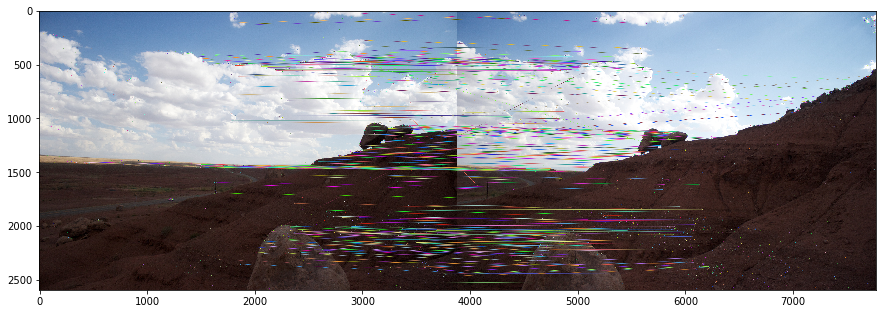

In [89]:
draw_matches(img1, img2, keypoints1, keypoints2, matches)

In [90]:
h = ransac(matches, keypoints1, keypoints2, sample_points=10, iterations=10000, check=False)

In [91]:
h_inv = np.linalg.inv(h)
h_inv /= h_inv[-1,-1]

In [92]:
h_inv

array([[ 7.25050319e-01,  3.45473990e-02,  1.35914530e+03],
       [-1.11625616e-01,  9.05586981e-01,  1.17633260e+02],
       [-7.16806803e-05, -2.60259813e-07,  1.00000000e+00]])

In [93]:
img2.shape

(2592, 3888, 3)

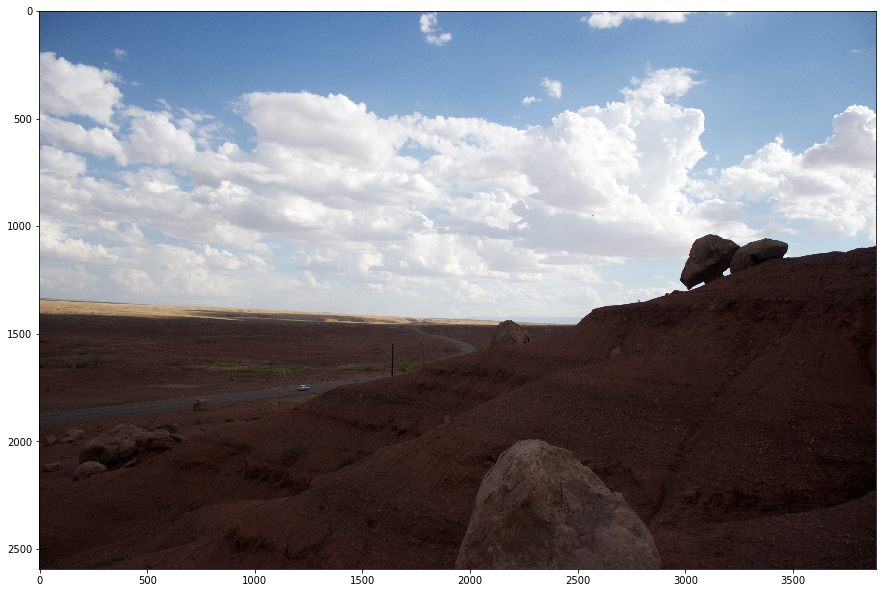

In [94]:
show_image(img1)

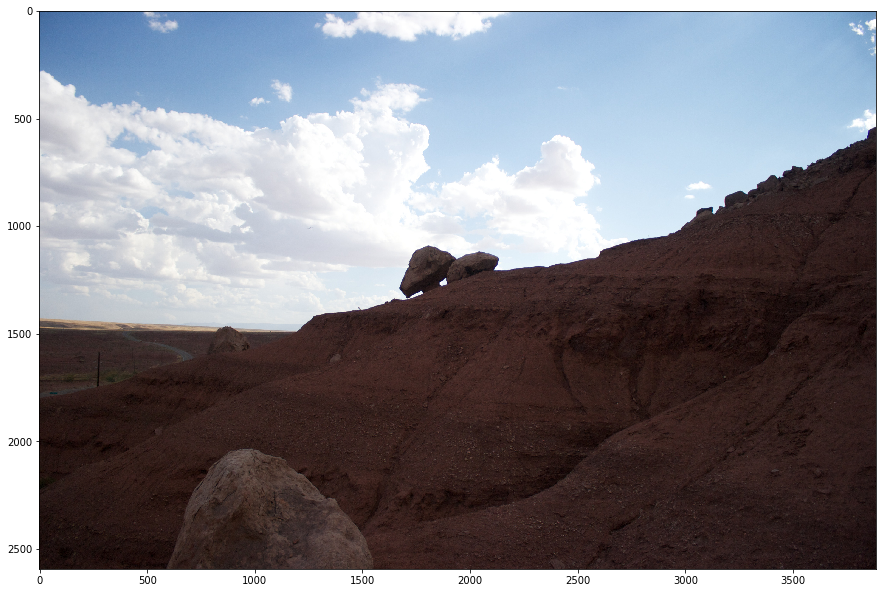

In [95]:
show_image(img2)

In [96]:
start = np.dot(h_inv , [0, 0, 1])
end = np.dot(h_inv, [img2.shape[1], img2.shape[0], 1])

In [97]:
start

array([1.3591453e+03, 1.1763326e+02, 1.0000000e+00])

In [98]:
end

array([4.26768779e+03, 2.03091432e+03, 7.20630921e-01])

In [99]:
# Caution : all dimesions are in img cordinates not array!! x,y = y,x

def get_new_img_coordinates(h, img):
    def get_img_coordinates(h, arr):
        homogenous_pt = np.dot(h, arr)
        homogenous_pt = (homogenous_pt/homogenous_pt[-1])[:-1]
        return homogenous_pt
    img_x, img_y = img.shape[1], img.shape[0]

    left_upper_coordinate = get_img_coordinates(h, [0, 0, 1])
    left_lower_coordinate = get_img_coordinates(h, [0, img_y, 1])
    right_upper_coordinate = get_img_coordinates(h, [img_x, 0, 1])
    right_lower_coordinate = get_img_coordinates(h, [img_x, img_y, 1])

    key_x = lambda x: x[0]
    key_y = lambda y : y[1]
    
    points_list = [left_upper_coordinate, left_lower_coordinate, right_upper_coordinate, right_lower_coordinate]
    print(points_list)
    min_x = min(points_list, key = key_x)[0]
    min_y = min(points_list, key = key_y)[1]
    max_x = max(points_list, key = key_x)[0]
    max_y = max(points_list, key = key_y)[1]
    
    print("min_x = %f min_y = %f max_x = %f max_y %f" %(min_x, min_y, max_x, max_y))
#     new_y = max_y - min_y
    new_y = img_y 
    new_x = max_x - min_x
    
    print(" x = %f y = %f" %(new_x, new_y))
    return ceil(new_x), ceil(new_y)


In [100]:
new_img_coords = get_new_img_coordinates(h, img2)

[array([-1857.45432917,  -358.85315353]), array([-2012.4952317 ,  2895.00847254]), array([2513.04780916,  179.86924874]), array([2429.73942389, 2531.44490957])]
min_x = -2012.495232 min_y = -358.853154 max_x = 2513.047809 max_y 2895.008473
 x = 4525.543041 y = 2592.000000


In [108]:
result = cv2.warpPerspective(img1, h, new_img_coords)

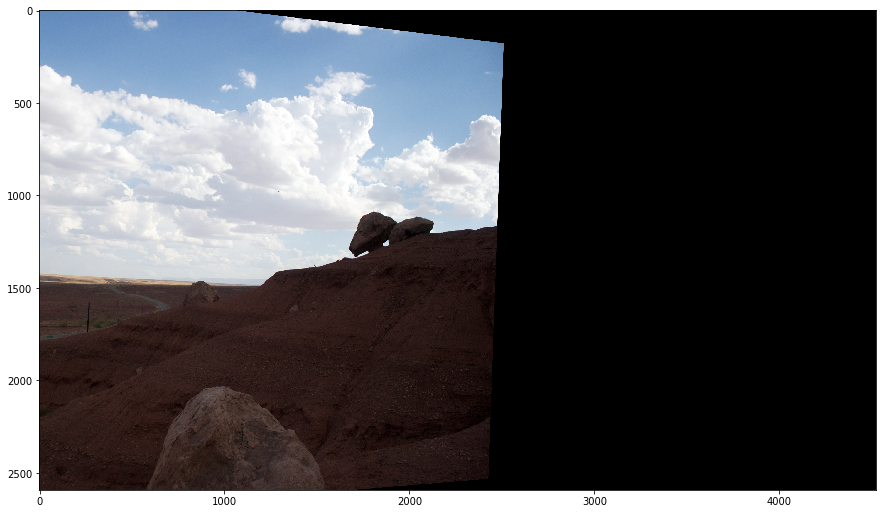

In [109]:
show_image(result)

In [110]:
result.shape

(2592, 4526, 3)

In [104]:
# Works : result[0:img2.shape[0], 0:img2.shape[1]] = img1
result[0:img1.shape[0], 0:img1.shape[1]] = img1

In [105]:
result.shape

(2592, 4526, 3)

In [106]:
img2.shape

(2592, 3888, 3)

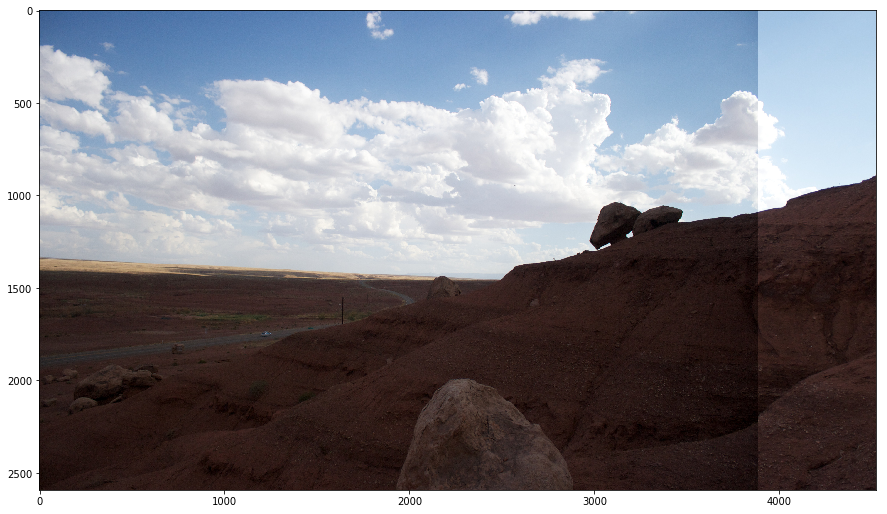

In [107]:
show_image(result)